In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#подгружаю библиотеки
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.preprocessing import LabelEncoder

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import PIL
from PIL import Image
from torch.utils.data import Dataset
import natsort
from pathlib import Path

import pandas as pd


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda', index=0)

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
!ls 

drive  sample_data


#### Подготовка данных

In [ ]:
# Трансформирую изображения, перевожу в торч-тензоры и загружаю датасет
transforms = transforms.Compose([
                                 transforms.CenterCrop(244),
                                 transforms.Resize(224),
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225] )
])
data_dir = '/content/drive/MyDrive/Simp/train'

image_datasets = torchvision.datasets.ImageFolder(root=data_dir, transform=transforms)


In [ ]:
class_names = image_datasets.classes

In [ ]:
#Кол-во классов в датасете
len(class_names)

42

In [ ]:
# Классы и соответствующие им индексы
image_datasets.class_to_idx

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

In [ ]:
set = {'train': [], "val": []}

In [ ]:
# Разбиваю датасет на тестовый и валидационный набор
set['train'], set['val']= torch.utils.data.random_split(image_datasets, (19000, 1700))

In [ ]:
# Подготовлю даталодеры из датасетов
dataloaders = {x: torch.utils.data.DataLoader(set[x], batch_size=10,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [ ]:
# Перевпроверю кол-во тензоров в каждом наборе 
dataset_sizes = {x: len(set[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 19000, 'val': 1700}


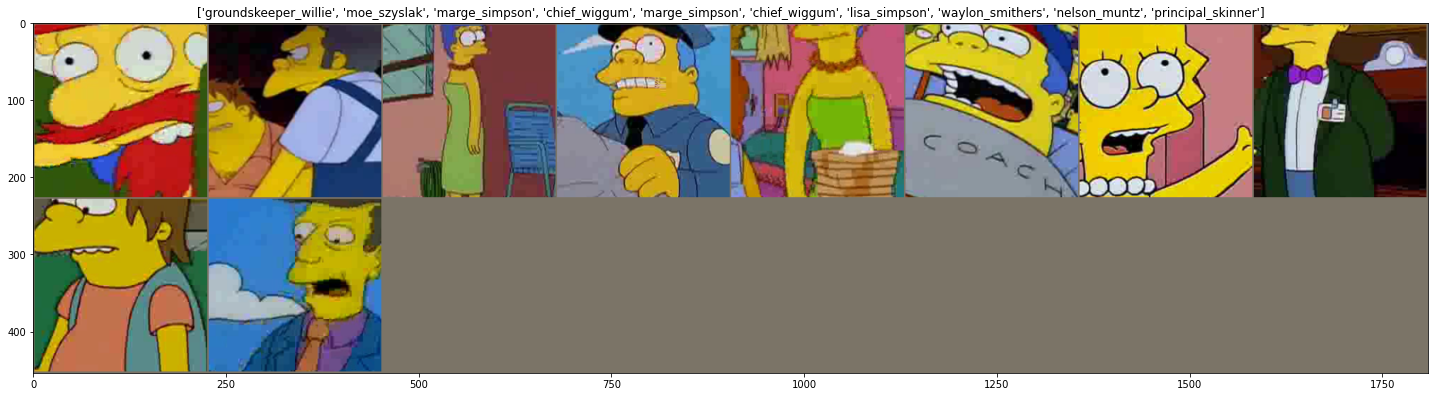

In [ ]:
# Изображения, соответствующие одному батчу
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(25, 25))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Получим 1 батч  из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Посмотрю на тензор одного изображения
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[ 0.8447,  0.8618,  0.9474,  ...,  0.4851,  0.4337,  0.4337],
         [ 0.8618,  0.8789,  0.9474,  ...,  0.4679,  0.4337,  0.4337],
         [ 0.9474,  0.9474,  0.9474,  ...,  0.4337,  0.4337,  0.4337],
         ...,
         [ 1.9578,  1.9407,  1.8893,  ...,  0.2796,  0.2796,  0.2796],
         [ 1.8550,  1.7865,  1.8893,  ...,  0.3481,  0.3481,  0.3481],
         [ 1.8379,  1.7523,  1.8893,  ...,  0.3652,  0.3652,  0.3652]],

        [[ 1.2381,  1.2556,  1.3431,  ..., -1.1779, -1.1779, -1.1779],
         [ 1.2556,  1.2731,  1.3431,  ..., -1.1779, -1.1779, -1.1779],
         [ 1.3431,  1.3431,  1.3431,  ..., -1.1779, -1.1779, -1.1779],
         ...,
         [ 2.1134,  2.0959,  2.0434,  ..., -1.2479, -1.2479, -1.2479],
         [ 2.0084,  1.9384,  2.0434,  ..., -1.2829, -1.2829, -1.2829],
         [ 1.9909,  1.9034,  2.0434,  ..., -1.3004, -1.3004, -1.3004]],

        [[ 2.1346,  2.1520,  2.2391,  ..., -1.8044, -1.8044, -1.8044],
         [ 2.1520,  2.1694,  2.2391,  ..., -1

In [ ]:
# Функция с алгоритмом тренировки модели
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # обучение
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизация (если трейн)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            

            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если качество улучшилось - обновляем веса
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
# Функция для измерения точности модели на валидационном датасете
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.softmax(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

Загрузка модели:

In [ ]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# размерность вектора фич на входе FC-слою
num_features = 9216
# Заменяем Fully-Connected линейный классификатор
model.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Адам
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

Training complete in 69m 25s
Best val Acc: 0.917059


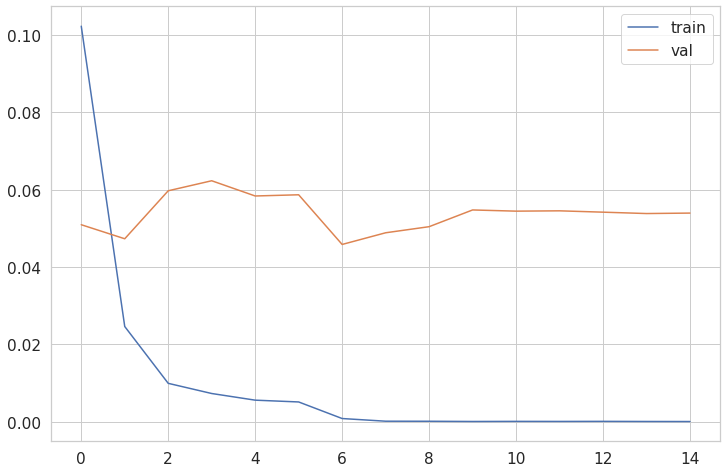

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Simp/AlexNet_fine_tune.pth'))

<All keys matched successfully>

Способ 2

In [ ]:
model_mixed = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
layers_to_unfreeze = 5

In [ ]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на линейный классификатор
model_mixed.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
model_mixed = model_mixed.to(device)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

train iter::   0%|          | 0/1900 [00:00<?, ?it/s]

val iter::   0%|          | 0/170 [00:00<?, ?it/s]

Training complete in 138m 21s
Best val Acc: 0.905294
CPU times: user 9min 53s, sys: 1min 28s, total: 11min 21s
Wall time: 2h 18min 21s


In [ ]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')